In [272]:
%matplotlib inline
import scipy.io as sio
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [238]:
data_file = 'hwkdataNEW.mat'
data_dict = sio.loadmat(data_file)

In [239]:
print(data_dict.keys())

dict_keys(['__header__', '__version__', '__globals__', 'x', 'y'])


In [240]:
x = data_dict['x']
y = data_dict['y']

In [241]:
x.shape

(247, 14)

In [242]:
y.shape

(247, 1)

# Split the data

Since the data consists of independent observations, we can shuffle the data set and select the first 70% for training, the second 15% for validation, and the last 15% for testing and reporting. If we expected a relationship between individual rows a more complicated sleection technique would be required (e.g. windowshading) that both allowed for data "stripes" of sufficient size to capture the inter-row relationships while being small enough to allow enough random samples in the data to make sure the model wasn't overtrained on some subset of the data.

First, join the input and output matrices to ensure we select associated records

In [243]:
data = np.concatenate([x, y], axis=1)
print(data.shape)

(247, 15)


In [244]:
unshuffled_first_row = data[0].copy()

In [245]:
np.random.shuffle(data)

In [246]:
assert not(np.array_equal(unshuffled_first_row, data[0]))

Now that the data is shuffled we can select the first 70% for training, 15% for validation, and 15% for testing.

In [247]:
rows = data.shape[0]
train_length = int(0.7 * rows)
val_length = int(0.15 * rows)
test_length = int(0.15 * rows)
print(f'70% of the data set is {train_length} rows')
print(f'15% of the data set is {val_length}')
# Ensure we are not leaving any data on the table
# Any extra rows we will throw into the training set
extra_rows = rows - train_length - val_length - test_length
print(f'There are {extra_rows} extra rows to add back to the training set')
train_length += extra_rows
print(f'The training set will have {train_length} rows')
print(f'The training set will have {val_length} rows')
print(f'The training set will have {test_length} rows')
print(f'There are a total of {train_length + val_length + test_length} rows of data')
# A test to make sure all data are being used
assert train_length + val_length + test_length == data.shape[0]

70% of the data set is 172 rows
15% of the data set is 37
There are 1 extra rows to add back to the training set
The training set will have 173 rows
The training set will have 37 rows
The training set will have 37 rows
There are a total of 247 rows of data


In [248]:
data_train = data[:train_length,:]
data_val = data[train_length:train_length+val_length,:]
data_test = data[train_length+val_length:,:]
print(f'The training set has {data_train.shape[0]} rows')
print(f'The validation set has {data_val.shape[0]} rows')
print(f'The testing set has {data_test.shape[0]} rows')

The training set has 173 rows
The validation set has 37 rows
The testing set has 37 rows


In order to ensure that the training set covers the entire range of our data set, we must find the row that contains the minimum and maximum of each of the input variables.

In [249]:
# Get the row numbers corresponding to maximum and minimum values in each column
max_indices = data.argmax(axis=0)
min_indices = data.argmin(axis=0)
# Join the two arrays of indices together
min_max_indices = np.append(max_indices, min_indices)
# Collapse the index arrays to their unique values
min_max_indices = np.unique(min_max_indices)
# Add that array to the training set
for rownum in min_max_indices:
    data_train = np.vstack([data_train, data[rownum]])
# Check the size of our training set now
print(f'The training set now has {data_train.shape[0]} rows')

The training set now has 189 rows


Filter duplicate rows from `data_train`. We don't want to overtrain on those rows.

In [250]:
data_train = np.unique(data_train, axis=0)
print(f'Training data now has {data_train.shape[0]} unique rows')

Training data now has 180 unique rows


# Solve matrix equation to find regression coefficients

We now have three data sets, `data_train`, `data_val`, and `data_test`. We can now fit a parametric linear regression model to fit the form $y = \sum_i a_i x_i + b$. We will do this by solving the equation $ \mathbf{x} \vec{a} = \vec{y} $, where the matrix $\mathbf{x}$ is right-padded with a column vector of $1$s in order to fit the last element of $\vec{a}$, representing the $y$-axis intercept. The naive solution to this is:
$$ 
    \mathbf{x}^{-1} \mathbf{x} \vec{a} = \mathbf{x}^{-1} \mathbf{x} \vec{y} \\
    \vec{a} = \mathbf{x}^{-1} \mathbf{x} \vec{y} 
$$
Since $\mathbf{x}$ is not square, however, we must replace the inverse with the pseudoinverse:
$$
    \mathbf{x}^T \mathbf{x} \vec{a} = \mathbf{x}^T \vec{y} \\
    \left( \mathbf{x}^T \mathbf{x} \right)^{-1} \left( \mathbf{x}^T \mathbf{x} \right) \vec{a} = \left( \mathbf{x}^T \mathbf{x} \right)^{-1} \mathbf{x}^T \vec{y} \\
    \vec{a} = \left( \mathbf{x}^T \mathbf{x} \right)^{-1} \mathbf{x}^T \vec{y}
$$

In [269]:
data_train_x = data_train[:,:-1]
data_train_y = data_train[:,-1]
# Pad data_train_x with column vector of ones
data_train_x = np.pad(data_train_x, ((0,0), (0,1)), 'constant', constant_values=(1))
print(f'Training input matrix of shape {data_train_x.shape}, training output of shape {data_train_y.shape}')
print(f'Example row: {data_train_x[0]}')

Training input matrix of shape (180, 15), training output of shape (180,)
Example row: [  22.    154.     66.25   24.7    34.     95.8    87.9    99.2    59.6
   38.9    24.     28.8    25.2    16.6     1.  ]


In [267]:
coefficients = np.dot(
    np.dot( # matrix multiplication
        np.linalg.inv( # inversion, calls out to BLAS libraries
            np.dot( # matrix multiplication again
                data_train_x.T, # Transpose
                data_train_x
            )
        ), 
        data_train_x.T # Transpose (again)
    ), 
    data_train_y
)

In [268]:
print(coefficients)

[  4.36659200e-02  -1.61246207e-01   5.60018471e-01   8.71070228e-01
  -5.73806095e-01  -4.60192088e-02   8.72024167e-01  -3.21837934e-01
   1.90998555e-01  -1.61744048e-01   1.60815120e-01   3.47446158e-01
   2.51497079e-01  -1.11527776e+00  -4.45632170e+01]


# Explore more correlation of inputs

In [278]:
column_names = ['Age', 'Weight', 'Height', 'Adiposity Index', 
                'Neck Circumference', 'Chest Circumference', 
                'Abdomen Circumference', 'Hip Circumference',
                'Thigh Circumference', 'Knee Circumference',
                'Ankle Circumference', 'Extended Bicep Circumference',
                'Forearm Circumference', 'Wrist Circumference',
                'Body Fat Percentage']

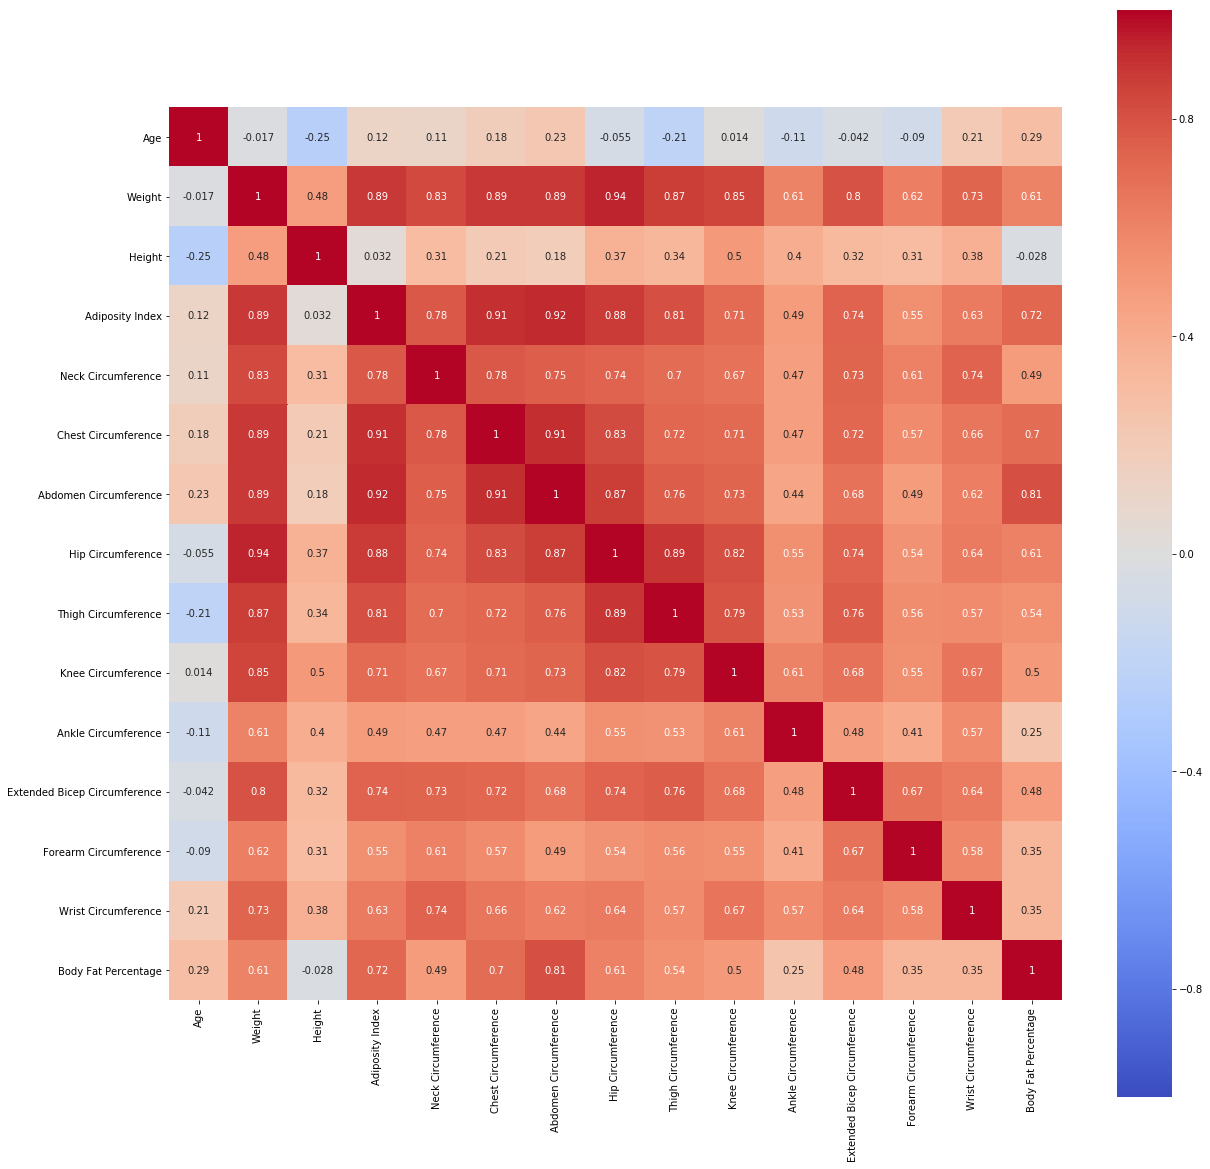

In [279]:
plt.figure(figsize=(20,20))
ax = sns.heatmap(np.corrcoef(data.T), vmin=-1,
                 vmax=1, center=0, cmap='coolwarm',
                 square=True, annot=True, xticklabels=column_names,
                 yticklabels=column_names)
plt.show()

# Search for data outliers

It's possible that some outliers in our data set are throwing things off. In order to quickly identify in which variables these outliers lie, we can check the `violin plot` and `box plot`.

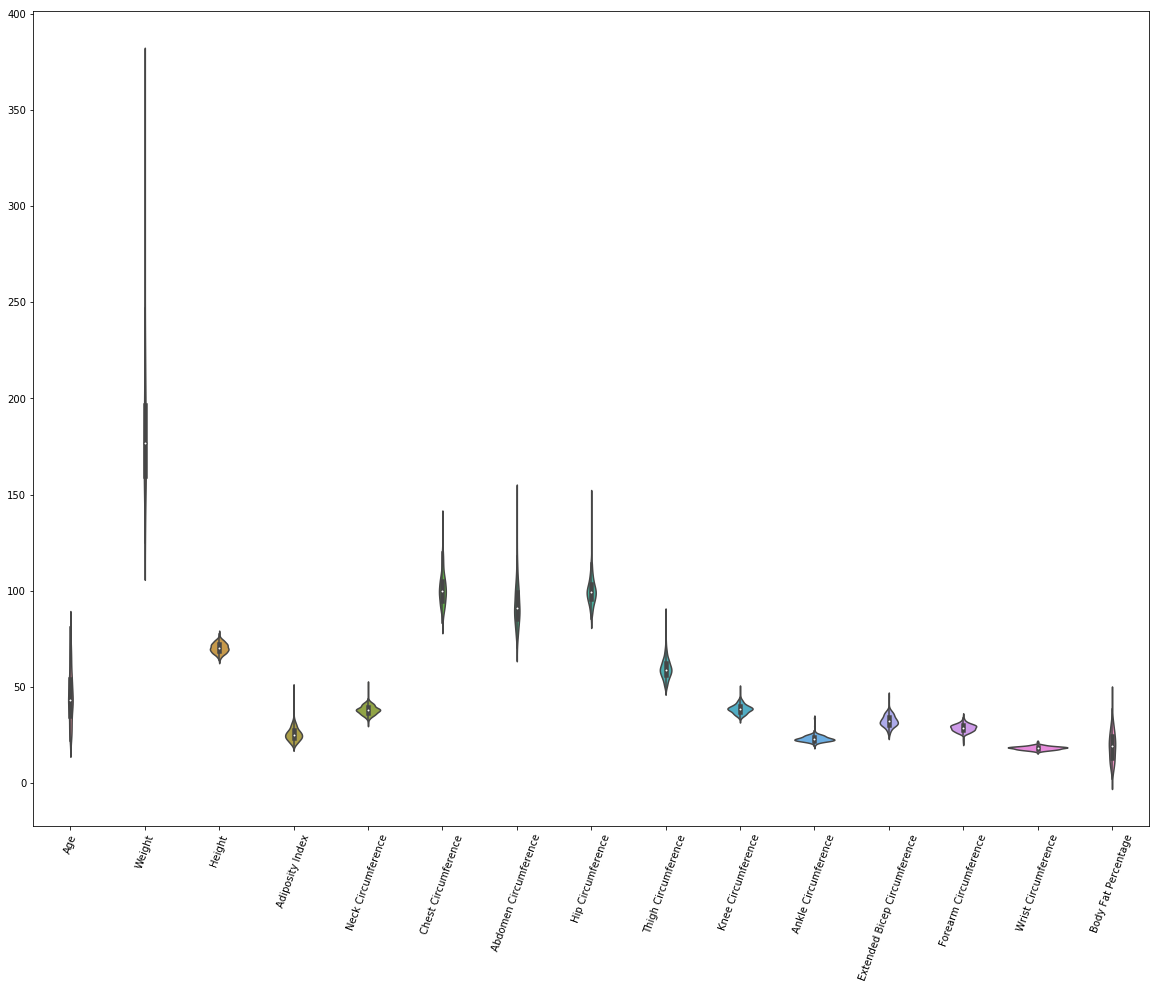

In [296]:
plt.figure(figsize=(20,15))
ax = sns.violinplot(data=data, names=column_names)
plt.xticks(rotation=70)
ax.set_xticklabels(column_names)
plt.show()

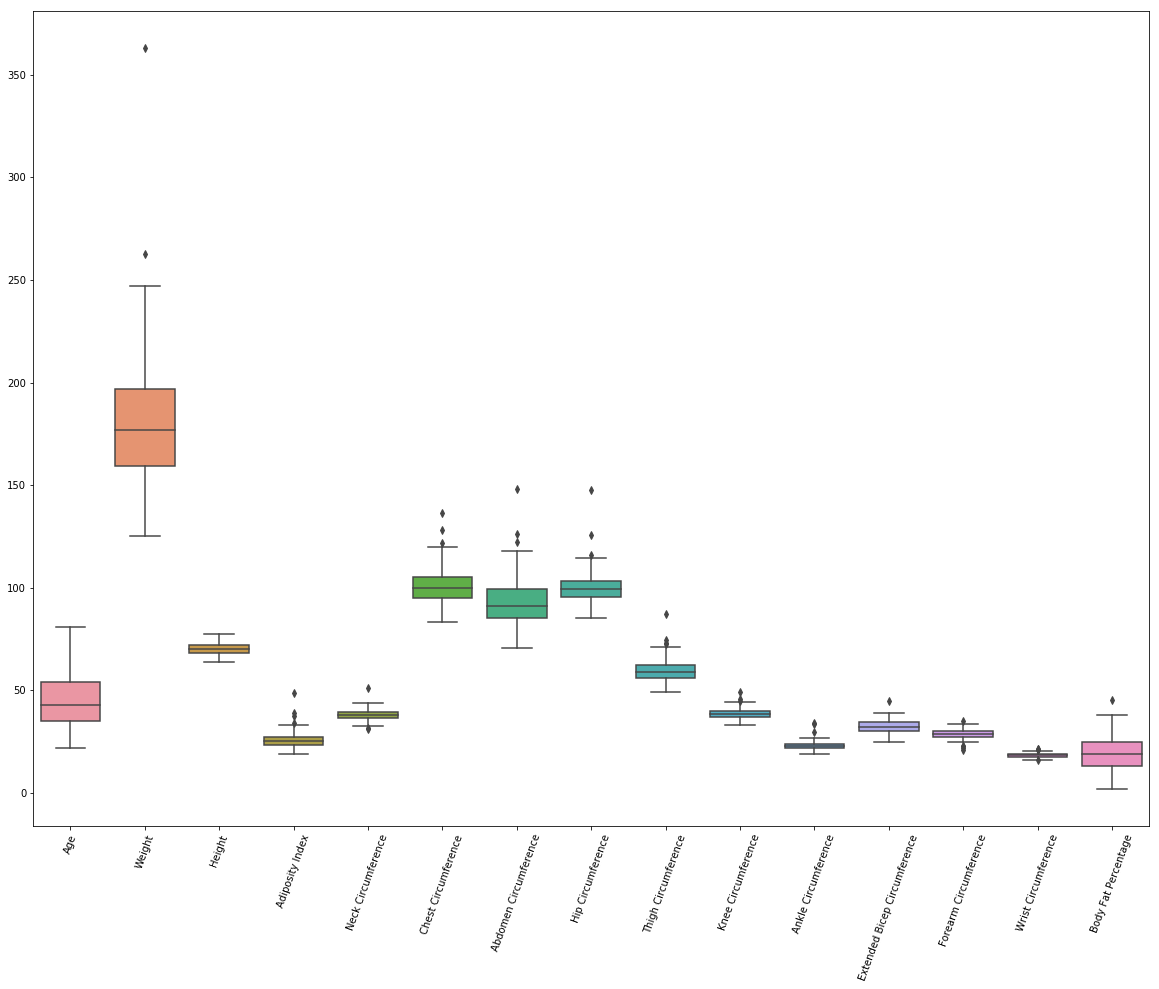

In [295]:
plt.figure(figsize=(20, 15))
ax = sns.boxplot(data=data)
plt.xticks(rotation=70)
ax.set_xticklabels(column_names)
plt.show()

From the box plot above it's clear that our most egregious outlier is a weight of nearly double our mean. In order to check this, we can quickly calculate how many standard deviations this value is away from the mean.

In [300]:
# Weights are in data column 1
weights = data[:, 1]
outlier_distance = (np.max(weights) - np.mean(weights)) / np.std(weights)
print(f'The outlier in the weights is {outlier_distance:0.2f} standard deviations from the mean')

The outlier in the weights is 6.33 standard deviations from the mean


While we're at it, let's perform the same analysis for each variable

In [302]:
max_outlier_distances = (np.max(data, axis=0) - np.mean(data, axis=0)) / np.std(data, axis=0)
print(max_outlier_distances)

[ 2.86075864  6.33372469  2.79589569  6.47149112  5.4601384   4.25392605
  5.18956686  6.77587169  5.40079345  4.41198674  6.36631982  4.20745437
  3.09234636  3.4332159   3.4157506 ]


This shows that there are still several outliers present in the data! These outliers were not as apparent in the box plot, likely because of the scaling. In order to make this easier to identify these outliers, let's re-scale our data set to be **MCUV** (mean centered with unit variance).

In [303]:
def zscore1(x, means=None, stds=None):
    """Scale a data set to mean center, unit variance
    
    If an array of mean values and an array of standard values are provided
    it will scale the dataset to those values instead.
    
    Parameters
    ----------
    x
        The dataset to be scaled
    means, optional
        An array of mean values. Should correspond to x.shape[1]
    stds, optional
        An array of standard deviation values. Should correspond to x.shape[1]
    """
    if means is None:
        means = np.mean(x, axis=0)
    if stds is None:
        stds = np.std(x, axis=0)

    xs = (x - means[np.newaxis, :]) / stds[np.newaxis, :]

    return xs, means, stds

In [304]:
data_s, data_means, data_stds = zscore1(data)

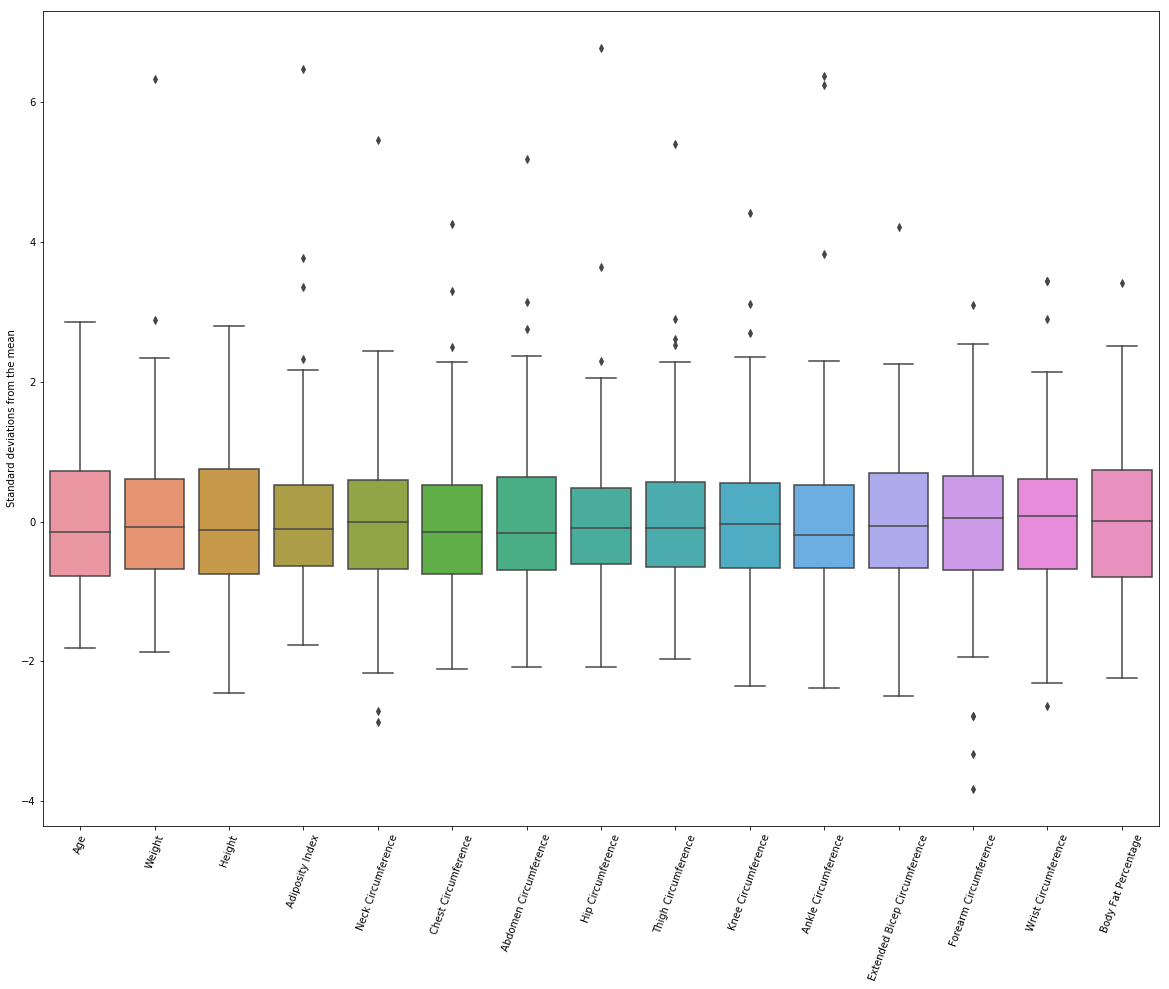

In [307]:
plt.figure(figsize=(20, 15))
ax = sns.boxplot(data=data_s)
plt.xticks(rotation=70)
ax.set_xticklabels(column_names)
ax.set_ylabel('Standard deviations from the mean')
plt.show()

From the box plot of the scaled data it's clear that there are a number of outliers which could be biasing our model.

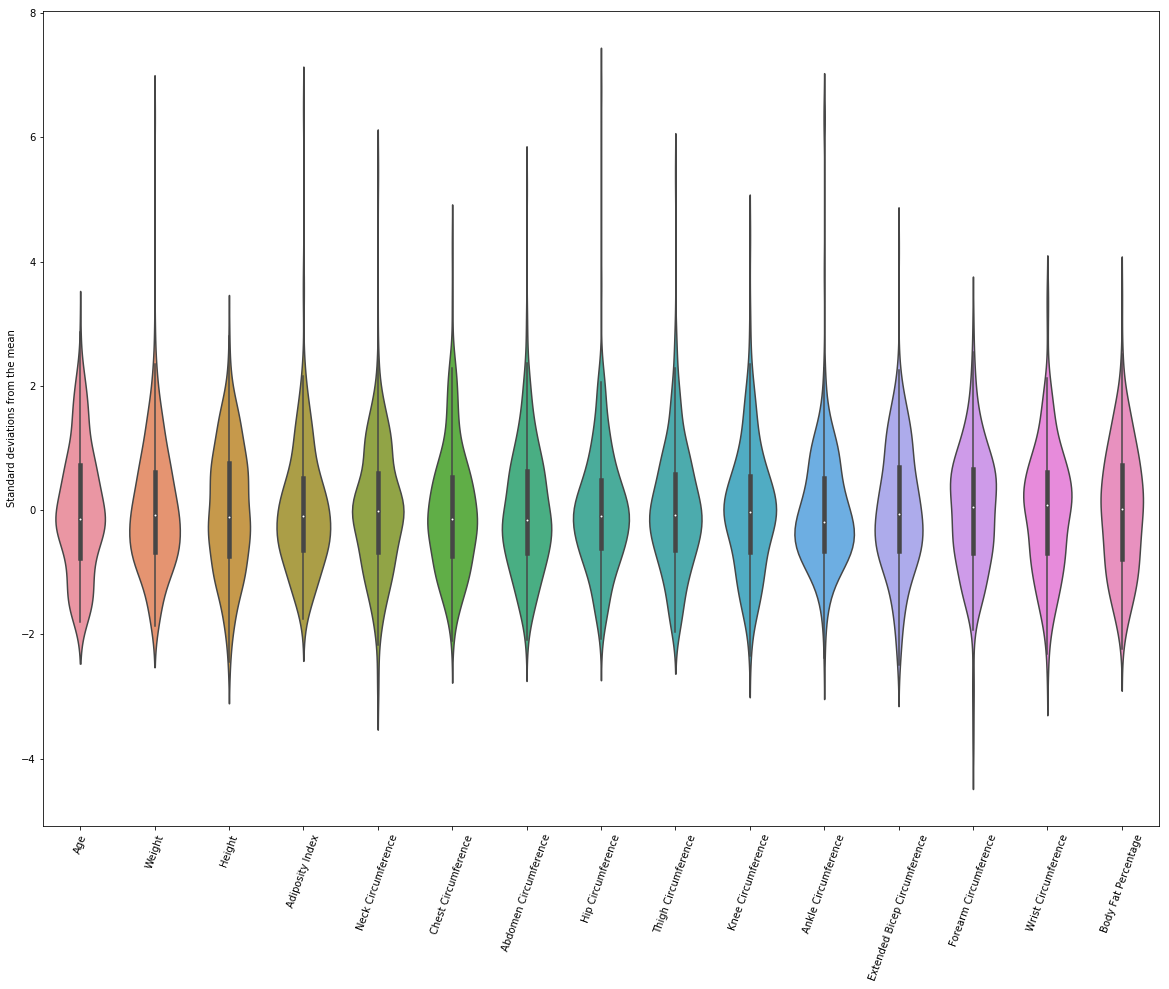

In [308]:
plt.figure(figsize=(20,15))
ax = sns.violinplot(data=data_s, names=column_names)
plt.xticks(rotation=70)
ax.set_xticklabels(column_names)
ax.set_ylabel('Standard deviations from the mean')
plt.show()

It's not clear from above what a violin plot brings to the table that a box and whiskers plot does not. But we can also employ the violin plot to validate that our testing data has the same approximate distribution as our training data by plotting the distribution of the training dataset on one side and the distribution of the test dataset on the other.

In [309]:
.15 / 0.85

0.17647058823529413